<a href="https://colab.research.google.com/github/pedromonteiro18/Pattern_Recognition/blob/master/Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.linalg import eigh


mat_content = sio.loadmat('face.mat')
1
# mat_content # Let's see the content... 
np.random.seed(1)

In [0]:
face_data = mat_content['X']
face_labels = mat_content['l']

#transpose to select test and training data
face_data = face_data
face_labels = face_labels

In [0]:
#20/80 test/training split
data_train, data_test, label_train, label_test = train_test_split(
    face_data.T, face_labels.T, test_size=0.2, random_state =1 )

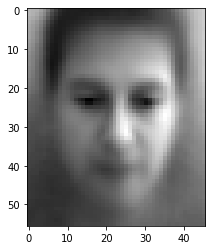

In [50]:
#compute average face vector
avg = np.mean(data_train, axis = 0)
plt.imshow(np.reshape(avg,(46,56)).T, cmap = 'gist_gray')

In [0]:
#subtract the mean face 
A = np.array([(data_train[0] - avg),(data_train[1] - avg)])

for i in range(2,len(data_train)):
    app = np.array([data_train[i] - avg])
    newA = np.append(A, app, axis = 0)
    A = newA
A = A.T

In [0]:
#compute covariance matrix 
S = np.dot(A, A.T)*1/len(data_train)

#Low-dimensional computation of eigenspace 
S2 = np.dot(A.T, A)*1/len(data_train)

In [0]:
# eigenvectors and eigenvalues
eigvals, eigvecs = np.linalg.eig(S)
eigvalsLow, eigvecsLow = np.linalg.eig(S2)
# print(eigvalsLow, eigvecsLow)

In [54]:
from sklearn import preprocessing
N=S2.shape[0]
M = 416
Meigvals, Meigvecs = eigh(S2, eigvals=(N-M, N-1))

eigvecsM = Meigvecs.astype(float)
eigvecsM = preprocessing.normalize(np.dot(A, eigvecsM).T)

#represent each normalized face by its projections
Wn = np.dot(A[:,[100]].T, eigvecsM.T)
print(Wn.shape)
# print(np.sort(eigvalsLow)[::-1])


(1, 416)


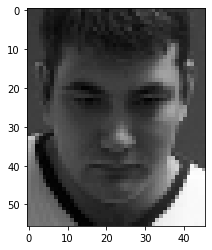

In [55]:
#reconstruction test face 
face_100 = data_train.T[:,100]
face_100 = np.reshape(face_100,(46,56))
plt.imshow(face_100.T, cmap= 'gist_gray')

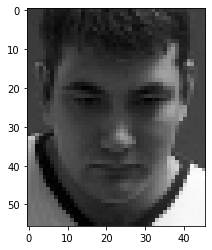

In [56]:
# sumCols = np.array([[None for x in range(2576)] for y in range(1)]).T
# sumCols = Wn[:,0].reshape(-1,1)
# for i in range(1, len(Wn[0])):
#     cols = Wn[:,i].reshape(-1,1)
#     sumCols += np.reshape(cols, (2576, 1))
sumCols = np.dot(Wn, eigvecsM)

#reconstruct 
new_100 = avg.reshape((2576,1)) + sumCols.T
new_100_reshaped = np.reshape(new_100,(46,56))
#new_100 = (255-np.reshape(new_100,(46,56)))
plt.imshow(new_100_reshaped.T, cmap = 'gist_gray')

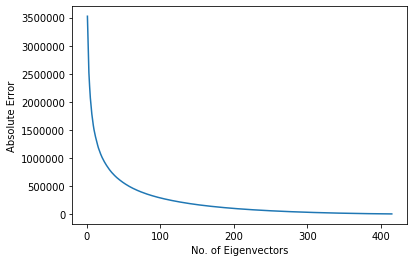

In [57]:
# Calculating the reconstruction error
x = []
y = []
for M in range(1,N):
  Meigvals_new, Meigvecs_new = eigh(S2, eigvals=(N-M, N-1))
  J = np.absolute(np.sum(Meigvals)-np.sum(Meigvals_new))
  x.append(M)
  y.append(J)

plt.xlabel('No. of Eigenvectors')
plt.ylabel('Absolute Error')
plt.plot(x,y)


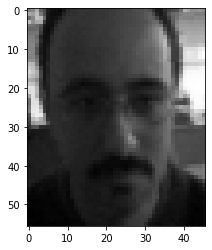

In [58]:
# nearest neighbour test face
test_face = data_test.T[:,25]
test_face = np.reshape(test_face,(46,56))
plt.imshow(test_face.T, cmap= 'gist_gray')

In [59]:
W = np.dot(A.T, eigvecsM.T)
print(W.shape)
test_face_normalized = data_test[25] - avg 
print(test_face_normalized.shape)
W_test = np.dot(test_face_normalized, eigvecsM.T)
print(W_test.shape)
print(label_test[25])

(416, 416)
(2576,)
(416,)
[50]


3 1
(2576, 1)
label [50]


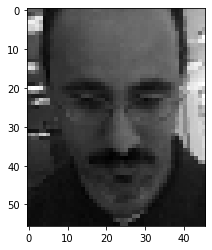

In [60]:
def distance(instance1, instance2):
    # just in case, if the instances are lists or tuples:
    instance1 = np.array(instance1) 
    instance2 = np.array(instance2)
    
    return np.linalg.norm(instance1 - instance2)
  
def get_neighbors(training_set, 
                  labels, 
                  test_instance, 
                  k, 
                  distance=distance):
    """
    get_neighors calculates a list of the k nearest neighbors
    of an instance 'test_instance'.
    The list neighbors contains 3-tuples with  
    (index, dist, label)
    where 
    index    is the index from the training_set, 
    dist     is the distance between the test_instance and the 
             instance training_set[index]
    distance is a reference to a function used to calculate the 
             distances
    """
    distances = []
    for index in range(len(training_set)):
        dist = distance(test_instance, training_set[index])
        distances.append((training_set[index], dist, labels[index]))
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    return neighbors


im = get_neighbors(W, label_train, W_test, 1, distance=distance)
print(len(im[0]), len(im))
image, _, label= im[0]
# im = np.reshape(image,(46,56))
# plt.imshow(im.T, cmap= 'gist_gray')
sumCols = np.dot(image, eigvecsM)
#reconstruct 
neighbour = avg.reshape((2576,1)) +  np.reshape(sumCols,(2576,1))
print(neighbour.shape)
neighbour = np.reshape(neighbour,(46,56))
#new_100 = (255-np.reshape(new_100,(46,56)))
plt.imshow(neighbour.T, cmap = 'gist_gray')
print("label", label)

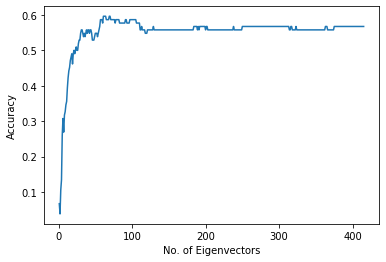

In [63]:
x=[]
y=[]
for M in range(1,416):
  Meigvals_new, Meigvecs_new = eigh(S2, eigvals=(N-M, N-1))
  eigvecsM = Meigvecs_new.astype(float)
  eigvecsM = preprocessing.normalize(np.dot(A, eigvecsM).T)
  total = 0
  correct = 0

  W = np.dot(A.T, eigvecsM.T)
  for test_index in range(len(data_test)):
    test_face_normalized = data_test[test_index] - avg 
    W_test = np.dot(test_face_normalized, eigvecsM.T)
    im = get_neighbors(W, label_train, W_test, 1, distance=distance)
    image, _, label= im[0]
    if label == label_test[test_index]:
      correct += 1
    total += 1
  x.append(M)
  y.append(correct/total)

plt.xlabel('No. of Eigenvectors')
plt.ylabel('Accuracy')
plt.plot(x,y)

In [0]:
#---------------------------------- QUESTION 2 -------------------------------------------#
# Split the data into 4 parts (104 images each)
train_data = np.split(data_train, 4)
test_data = np.split(data_test, 4)
train_label = np.split(label_train, 4)
test_label = np.split(label_test, 4)

def createA(data):
  avg = np.mean(data, axis = 0)
  A = np.empty([0,2576])
  for i in range(len(data)):
    app = np.array([data[i] - avg])
    newA = np.append(A, app, axis = 0)
    A = newA
  A = A.T
  return  A, avg

In [89]:


# PCA trained by only the first subset


#subtract the mean face of dataset 1
A=[None] * 4
A[0], avg1 = createA(train_data[0])

print(len(A[0]))

#Low-dimensional computation of eigenspace of dataset 1
S = np.dot(A[0].T, A[0])*1/len(train_data[0])
N=len(train_data[0])
M=len(train_data[0])
print("N", N, "M", M)
Meigvals, Meigvecs = eigh(S, eigvals=(N-M, N-1))

eigvecsM = Meigvecs.astype(float)
eigvecsM = preprocessing.normalize(np.dot(A[0], eigvecsM).T)
print(eigvecsM.shape)

print(type(S))

2576
N 104 M 104
(104, 2576)
<class 'numpy.ndarray'>


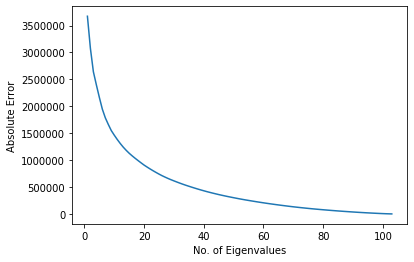

In [77]:
# Calculating the reconstruction error for dataset 1
x = []
y = []
for M in range(1,N):
  Meigvals_new, Meigvecs_new = eigh(S, eigvals=(N-M, N-1))
  J = np.absolute(np.sum(Meigvals)-np.sum(Meigvals_new))
  x.append(M)
  y.append(J)
  

plt.xlabel('No. of Eigenvalues')
plt.ylabel('Absolute Error')
plt.plot(x,y)

In [0]:
def incremental_PCA(mean1, mean2, N1, N2, eigvecs1, eigvecs2, S1, S2):
  N3 = N1 + N2
  mean3 = (N1*mean1 + N2*mean2)/N3
  S3 = (N1/N3)*S1 + (N2/N3)*S2 + ((N1*N2)/(N3**2))*np.dot((mean1-mean2),(mean1-mean2).T)
  phi = np.concatenate([eigvecs1.T, eigvecs2.T, (np.asarray([mean1-mean2])).reshape(2576, -1)], axis = 1)
  phi, _ =  np.linalg.qr(phi)
  matrix = np.dot((phi.T), S3)
  matrix = np.dot(matrix, phi)
  eigvals, R = np.linalg.eig(matrix)
  eigvecs = np.dot(phi, R).T
  print((eigvecs1.T.shape))
  return eigvals, eigvecs, mean3, S3, N3

In [131]:
#Incremental PCA

# High dimensional calculation of S1 required for incremental PCA
S1 = np.dot(A[0], A[0].T)*1/len(train_data[0])
# avg_1 = avg_1
N1 = N
print(N)
Sbatch = [None]*4
# Sbatch[0] = S1; but this line is not required as S1 is already assigned
# Assuming the first batch has been carried out (in the cells above)
# The following loop incrementally adds new data batches to calculate S3
eigvecs1 = eigvecsM
for batch in range(1, 4):

  # Creating A2 to calculate S2
  A[batch], avg2 = createA(train_data[batch])
  N2 = len(A[batch])
  print(N2)

  # Low dimensional calculation of S2 to find eigvecs faster
  Sbatch[batch] = np.dot(A[batch].T, A[batch])*1/len(train_data[batch])
  
  eigvals2, eigvecs2 = np.linalg.eig(Sbatch[batch])
  eigvecs2 = eigvecs2.astype(float)
  eigvecs2 = preprocessing.normalize(np.dot(A[batch], eigvecs2).T)
  # High dimensional calculation of S2 as required for incremental PCA
  S2 = np.dot(A[batch], A[batch].T)*1/len(train_data[batch])
  # Incremental PCA done on 2 data sets
  print("Eigvecs1", eigvecs1.shape, "Eigvecs2", eigvecs2.shape)
  eigvals3, eigvecs3, avg3, S3, N3 = incremental_PCA(avg1, avg2, N1, N2, eigvecs1, eigvecs2, S1, S2)
 
  
  # In the next iteration we want S1 to be the current cumulative S3
  S1 = S3
  N1 = N3
  avg1 = avg3
  eigvecs1 = eigvecs3



print(S3.shape, eigvecs3.shape)



104
2576
Eigvecs1 (104, 2576) Eigvecs2 (104, 2576)
(2576, 104)
2576
Eigvecs1 (209, 2576) Eigvecs2 (104, 2576)
(2576, 209)
2576
Eigvecs1 (314, 2576) Eigvecs2 (104, 2576)
(2576, 314)
(2576, 2576) (419, 2576)


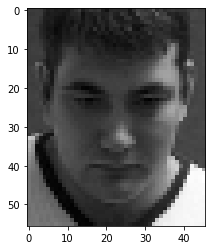

In [138]:
# face reconstruction with Incremental PCA eigvecs
A, avg = createA(data_train)
Wn = np.dot(A[:,[100]].T, eigvecs3.T)
sumCols = np.dot(Wn, eigvecs3)

#reconstruct 
reconstructed_face = np.absolute(avg.reshape((2576,1)) + sumCols.T)
reconstructed_face = np.reshape(reconstructed_face,(46,56))
#new_100 = (255-np.reshape(new_100,(46,56)))
plt.imshow(reconstructed_face.T, cmap = 'gist_gray')
